In [1]:
import IPython.display as ipd # load a local WAV file and PLAY!!!
from scipy.signal import butter , filtfilt

import os
import pandas as pd
import librosa
import librosa.display
import glob 
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import os, fnmatch

import numpy as np
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM,Conv2D, Conv1D,MaxPool1D,Conv2D, MaxPool2D,BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import classification_report, accuracy_score
import itertools
from keras.layers import TimeDistributed, Bidirectional

from livelossplot import PlotLossesKeras # To plot the NN realtime!

from tqdm import tqdm


%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
PATH_A = 'inputsound/set_a/'
PATH_B = 'inputsound/set_b/'
MAX_AUDIO_DURATION = 12

# Low pass filter

In [3]:
# LPF compressed
def LPF(signal):    
    fc =300
    sr = 22050
    w = fc/(sr/2)
    b,a = butter(3,w , btype = "lowpass")

    x = filtfilt(b,a, signal)
    x = x/x.max()

    return x

 # MFCC

**FUNCTION AUDIO_NORM**

* Normalize data.

In [4]:
def audio_norm(data):
    data = (data-min(data))/(max(data)-min(data)+0.0001)
    return data-0.5

**FUNCTION GET_FILENAMES**

Gets filenames if they are not in ["Aunlabelledtest", "Bunlabelledtest","artifact"]. Which results in:
 - {'artifact', 'extrahls', 'murmur', 'normal'}: for set_a
 - {'extrastole', 'murmur', 'normal'}: for set_b

In [5]:
def get_filenames(path):
    files = []
    for file in glob.glob(path + "/*"):
        if file.split("\\")[-1].split("_")[0] not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
            files.append(file.split("\\")[1])
    return files

**FUNCTION GET_MFCC**

Gets MFCC array for different sets.

In [6]:
def get_mfcc_CNN(path, file_names, duration = MAX_AUDIO_DURATION, sr=22050):
    
    input_length=sr*duration
    
    # function to load files and extract features
    data = []
    for file_name in tqdm(file_names):
        
        try:
            sound_file = path + file_name        
            signal, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') #duration=duration 
            dur = librosa.get_duration(y = signal, sr=sr)
            
            # pad audio file same duration
            if (round(dur) < duration):
                y = librosa.util.fix_length(signal, input_length) 
            #normalized raw audio 
            signal_norm = audio_norm(y)
            
            #LPF
            X = LPF(signal_norm)
            #MFCC      
            mfccs = librosa.feature.mfcc(y = X, sr=sr, n_mfcc=40).T
            
        except Exception as e:
            print("Error encountered while parsing file: ", file_name)        
        feature = mfccs.reshape(*mfccs.shape,1)
        data.append(feature)
    return data

### Get files and mfccs

In [7]:
# CNN
a_files  = get_filenames(PATH_A)
a_sounds = get_mfcc_CNN(path = PATH_A , file_names = a_files, duration = MAX_AUDIO_DURATION) #Same duration for each file
b_files  = get_filenames(PATH_B)
b_sounds = get_mfcc_CNN(path = PATH_B , file_names = b_files, duration = MAX_AUDIO_DURATION) #Same duration for each file

100%|████████████████████████████████████████████████████████████████████████████████| 461/461 [01:04<00:00,  7.15it/s]


### Get labels

{'artifact', 'extrahls', 'murmur', 'normal'}: for set_a

{'extrastole', 'murmur', 'normal'}: for set_b
* 0 = normal
* 1 = murmur
* 2 = extrasystole
* 3 = artifact

In [8]:
# All filenames together
files = a_files + b_files

In [9]:
labels = []
len_classes = 3
for file in files:
    if 'normal' in file:
        labels.append(0)
    elif 'murmur' in file:
        labels.append(1)
    elif 'extrastole' in file:
        labels.append(2)
    elif 'extrahls' in file:
        labels.append(2)


In [10]:
# CNN
ab = a_sounds+b_sounds
ab = [np.expand_dims(i, 0) for i in ab]
X = np.concatenate(ab)
y = np.asarray(labels)

# Train-test-split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,random_state=1000, shuffle=True)

# To binary
y_train = np.array(keras.utils.to_categorical(y_train, len_classes)) 
y_test = np.array(keras.utils.to_categorical(y_test, len_classes))

In [12]:
print (f"Labels shape: {y.shape}")
print (f"Data size of the array: {y.size}\n" )
print (f"Audio data shape: {X.shape}" )
print (f"Data size of the array: {X.size}\n" )
print (f"Training data shape: {X_train.shape}")
print (f"Training label shape: {y_train.shape}\n" )
print (f"Validation data shape: {X_test.shape}")
print (f"Validation label shape: {y_test.shape}")


Labels shape: (545,)
Data size of the array: 545

Audio data shape: (545, 517, 40, 1)
Data size of the array: 11270600

Training data shape: (436, 517, 40, 1)
Training label shape: (436, 3)

Validation data shape: (109, 517, 40, 1)
Validation label shape: (109, 3)


 # CNN Model

##### Build CNN

In [28]:
input_shape = X_train.shape[1:]

# create model 
model = Sequential()

# 1st layer
model.add(Conv2D(32,(3,3),  activation = "relu", input_shape = input_shape))#, data_format='channels_first'))
model.add(MaxPool2D((3,3), strides = (2,2), padding = 'same'))
model.add(BatchNormalization()) #normalizes the activations in a layer

# 2nd layer
model.add(Conv2D(32,(3,3),  activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3,3), strides = (2,2), padding = 'same'))
model.add(BatchNormalization()) #normalizes the activations in a layer

# 3rd layer
model.add(Conv2D(32,(2,2),  activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((2,2), strides = (2,2), padding = 'same'))
model.add(BatchNormalization()) #normalizes the activations in a layer

# Flatten (1D) the output and feed it into dense layer
model.add(Flatten())
model.add(Dense(64, activation='relu')) # 64 neurons
model.add(Dropout(0.3)) # Dropout probability

# output layer
model.add(Dense(3, activation = 'softmax')) # as many neurons as number of classes = 3

In [29]:
# Compile de network
optimizer = Adam(learning_rate = 0.0001)
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

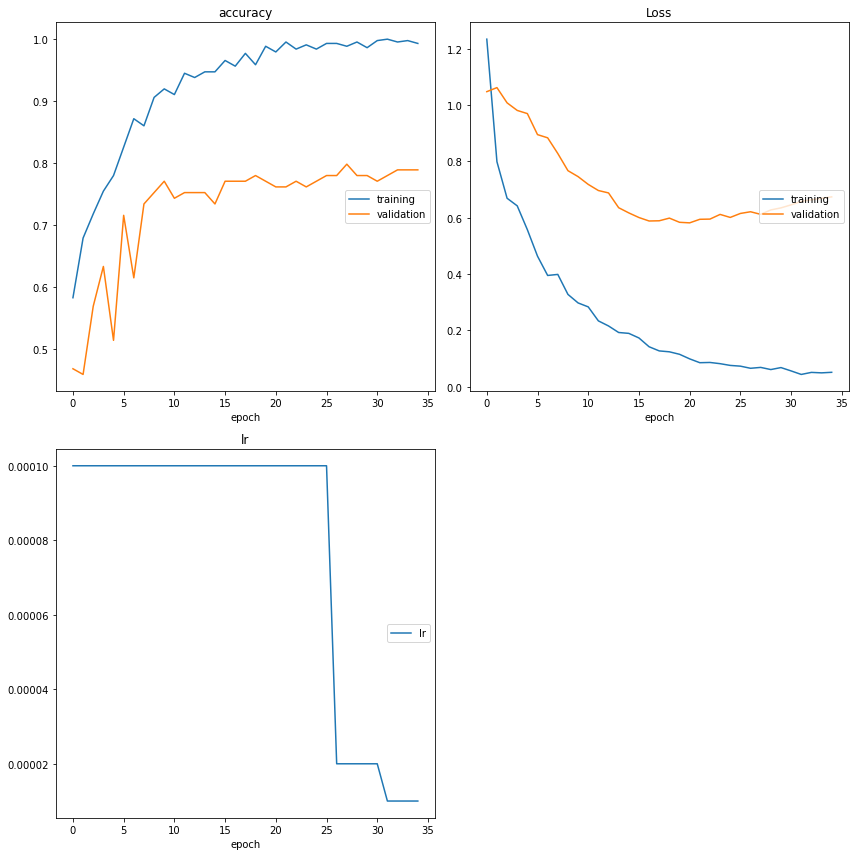

accuracy
	training         	 (min:    0.583, max:    1.000, cur:    0.993)
	validation       	 (min:    0.459, max:    0.798, cur:    0.789)
Loss
	training         	 (min:    0.044, max:    1.234, cur:    0.051)
	validation       	 (min:    0.582, max:    1.062, cur:    0.674)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
14/14 [==============================] - 5s 327ms/step - loss: 0.0511 - accuracy: 0.9931 - val_loss: 0.6741 - val_accuracy: 0.7890


In [30]:
# Train the model
max_patience = 30
max_epochs = 100
max_batch = 32

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience = max_patience, 
                               verbose=0, mode='max', 
                               restore_best_weights=False)

callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001),
                              early_stopping,
                              PlotLossesKeras()]

print("Training started..")
model.fit(X_train, y_train,
         validation_data = (X_test,y_test),
         batch_size = 32,
         epochs = 35,
          callbacks=callbacks)

In [31]:
# Evaluate the CNN
score = model.evaluate(X_train, y_train, verbose=0) 
print ("Model training score: ")
print(f"   Train loss = {score[0]} \n   Train acc = {score[1]}")

score = model.evaluate(X_test, y_test, verbose=0) 
print ("Model testing score: ")
print(f"   Test loss = {score[0]} \n   Test acc = {score[1]}")

Model training score: 
   Train loss = 0.039503760635852814 
   Train acc = 1.0
Model testing score: 
   Test loss = 0.6741142868995667 
   Test acc = 0.78899085521698


In [48]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

    # serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
